## Show:

- Making COVID infections, deaths, and infections/death ratio predictions on Metaculus more consistent with each other
- More broadly: a workflow that connects judgmental and model-based forecasting

## Setup:

In [0]:
%%capture
%pip install --quiet poetry  # Fixes https://github.com/python-poetry/poetry/issues/532
%pip install --quiet git+https://github.com/oughtinc/ergo.git

In [0]:
import ergo
import seaborn
import numpy as np

In [0]:
metaculus = ergo.Metaculus(username="oughtpublic", password="123456")

## Look at questions on Metaculus
* [total COVID infections before 2021](https://www.metaculus.com/questions/3529/how-many-infections-of-covid-19-will-be-estimated-to-have-occurred-before-2021-50k-1b-range/)
* [total COVID deaths before 2021](https://www.metaculus.com/questions/3530/how-many-people-will-die-as-a-result-of-the-2019-novel-coronavirus-covid-19-before-2021/)
* [chance of dying of COVID if you get it](https://www.metaculus.com/questions/3755/what-will-be-the-ratio-of-fatalities-to-total-estimated-infections-for-covid-19-by-the-end-of-2020/)



### Load these questions

In [0]:
q_infections = metaculus.get_question(3529, name="infections")
q_deaths = metaculus.get_question(3530, name="deaths")
q_ratio = metaculus.get_question(3755, name="ratio")

questions = [q_infections, q_deaths, q_ratio]

### Current community estimates for each question:

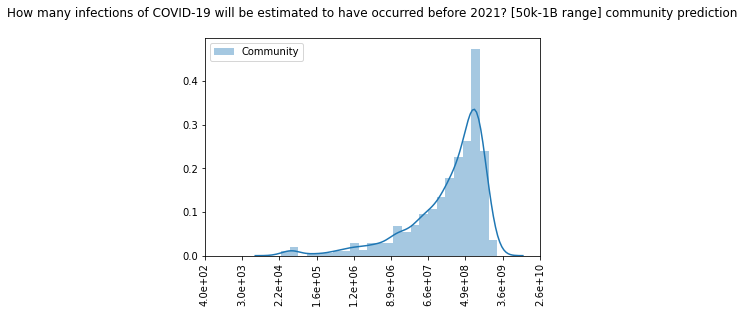

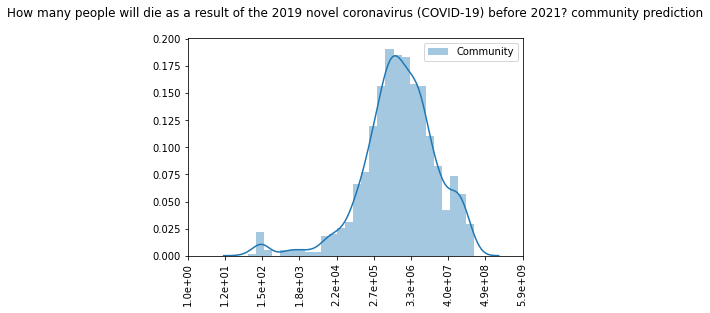

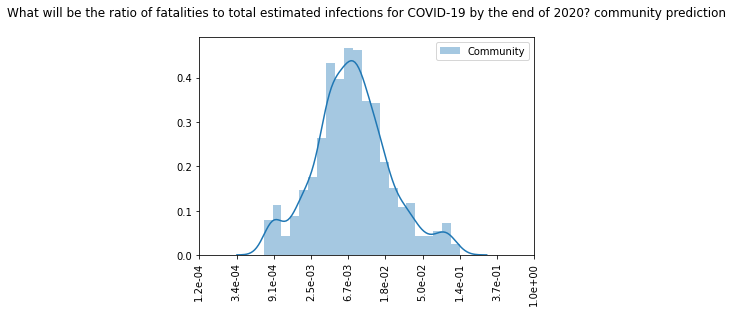

In [69]:
[question.show_community_prediction() for question in questions];

## Model deaths based on the infection and ratio predictions

Deaths = infections * deaths/infection

In [0]:
%%capture
def deaths_from_infections():
  infections = q_infections.sample_community()
  ratio = q_ratio.sample_community()
  modeled_deaths = q_deaths.sample_community()
  modeled_deaths = infections * ratio
  ergo.tag(modeled_deaths, "modeled_deaths")
  return modeled_deaths

samples = ergo.run(deaths_from_infections, num_samples=5000)

### How does our model prediction compare to the community prediction?

100%|██████████| 5000/5000 [00:19<00:00, 261.14it/s]


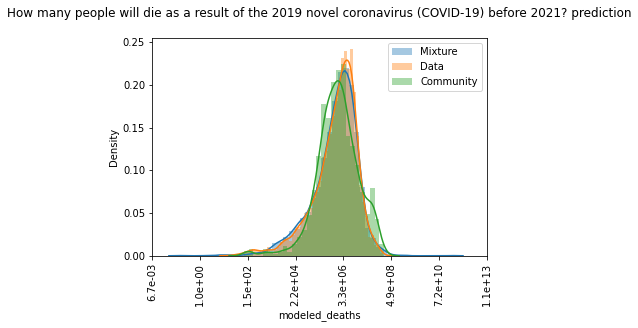

In [73]:
q_deaths.show_submission(samples["modeled_deaths"], show_community=True)

### Combine our model with the community prediction

Mostly defer to the community's predictions on the deaths question, but update a bit towards the model that's based on infections * deaths/infection.

In [0]:
%%capture
def deaths_adjusted():
  if ergo.flip(.66):
    deaths = q_deaths.sample_community()
  else:
    deaths = deaths_from_infections()
  ergo.tag(deaths, "adjusted_deaths")

samples = ergo.run(deaths_adjusted, num_samples=5000)

adjusted_samples = samples["adjusted_deaths"]

100%|██████████| 5000/5000 [00:19<00:00, 257.45it/s]


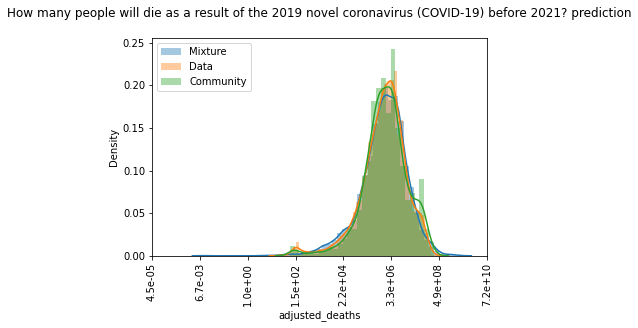

In [75]:
q_deaths.show_submission(adjusted_samples, show_community=True)

Submit new distribution on deaths to Metaculus

In [0]:
%%capture
q_deaths.submit_from_samples(adjusted_samples)

**TODO:** Apply the same idea to estimating infections from deaths